## 講習会実習課題レポート  (2024/06/19 宮崎聡 ハワイ観測所)

### 1. SciOps Night Log - 2024-03-23 で報告されているActuator8-60 Alarmが発生しているときの温度センサのデータを確認し、どのチャンネルが問題かを調べよ

#### 3/23の温度センサーデータを調べる

2024-03-24 05:27:29.4 PMFXS8-60 Temp MON1 Data : 3.2
2024-03-24 05:27:30.3 PMFXS8-60 Temp MON1 Data : 6553.4
2024-03-24 05:27:29.4 PMFXS8-60 Temp MON2 Data : 3.2
2024-03-24 05:27:30.3 PMFXS8-60 Temp MON2 Data : 3.2
2024-03-24 05:27:29.4 PMFXS8-60 Temp MON3 Data : 3.2
2024-03-24 05:27:30.3 PMFXS8-60 Temp MON3 Data : 0.3
2024-03-24 05:27:29.4 PMFXS8-60 Temp MON4 Data : 0.5
2024-03-24 05:27:30.3 PMFXS8-60 Temp MON4 Data : 0.2
2024-03-24 05:27:29.4 PMFXS8-60 Temp MON5 Data : 0.4
2024-03-24 05:27:30.3 PMFXS8-60 Temp MON5 Data : 0.7
2024-03-24 05:26:08.4 PMFXS8-60 Temp MON6 Data : 5.5
2024-03-24 05:26:09.4 PMFXS8-60 Temp MON6 Data : 5.5
2024-03-24 05:27:29.4 PMFXS8-60 Temp MON6 Data : 0.3
2024-03-24 05:27:30.3 PMFXS8-60 Temp MON6 Data : 0.6


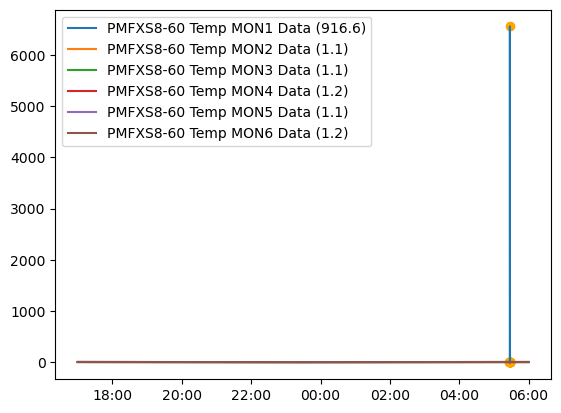

In [2]:
from telDav import FetchData
names = ["PMFXS8-60 Temp MON1 Data", 
         "PMFXS8-60 Temp MON2 Data",
         "PMFXS8-60 Temp MON3 Data",
         "PMFXS8-60 Temp MON4 Data",
         "PMFXS8-60 Temp MON5 Data",
         "PMFXS8-60 Temp MON6 Data"]
fetchData = FetchData.FetchData(startDatetime = '2024-03-23 17:00:00', 
                                stopDatetime =  '2024-03-24 06:00:00',
                                names = names)
fetchData.run()
df = fetchData.dataframe

import pandas as pd
import matplotlib.pyplot as plt
from telDav import findOutliers
import matplotlib.dates as mdates
import numpy as np

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
for name in names:
    ts = pd.Series(df[name].to_numpy(), index=df['datetime'])
    outliers = findOutliers.byPercentile(ts, 0.01)
    ax.plot(df['datetime'], df[name], label=f'{name} ({np.var(df[name]):.1f})')
    ax.scatter(outliers.index, outliers, color='orange')
    for t in outliers.index:
        print(f'{t.strftime("%Y-%m-%d %H:%M:%S.%f")[:21]} {name} : {ts[t]}')
            
plt.legend()
plt.show()

Ch1がHST 3/24 5:27AMに異常値を記録している

#### 過去1年のデータを調べてみる

/home/satoshi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


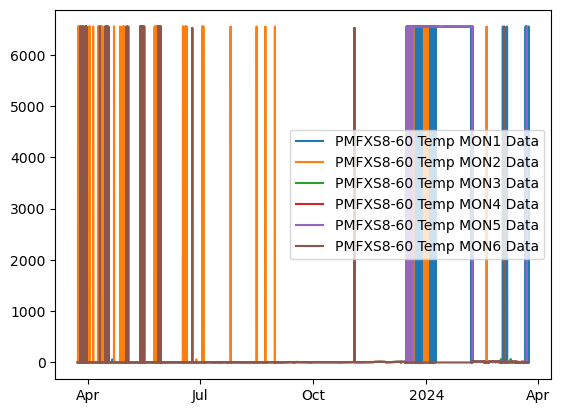

In [3]:
from telDav import FetchData
fetchData = FetchData.FetchData(startDatetime = '2023-03-23 17:00:00', 
                                stopDatetime =  '2024-03-24 06:00:00',
                                names = ["PMFXS8-60 Temp MON1 Data", 
                                         "PMFXS8-60 Temp MON2 Data",
                                         "PMFXS8-60 Temp MON3 Data",
                                         "PMFXS8-60 Temp MON4 Data",
                                         "PMFXS8-60 Temp MON5 Data",
                                         "PMFXS8-60 Temp MON6 Data"])
fetchData.run()
fetchData.draw()

異常値は、過去1年にも多数発生しているようだ。2023/09以前はCh2の異常が目立っていた。

### 2. 2024/03/19にLCUのひとつである、MCUのトラブルのTSCデータを調査せよ  （SciOps Night Log - 2024-03-19を参照せよ）課題2 : 課題1のLCU(MCU)データを確認し、ログデータから原因を考察せよ

#### MCUのALARMをトラブル報告前後で調べる

In [4]:
import datetime
from telDav import ApparatusStatus

apparatusStatus = ApparatusStatus.ApparatusStatus(startDatetime=datetime.datetime(2024, 3, 20, 4, 50, 0),
                                                  stopDatetime=datetime.datetime(2024, 3, 20, 5, 30, 0),
                                                  keyWords=["ALARM", "MCU"])
lines = apparatusStatus.run()
for l in lines:
    print(l)

/tscbin/tsc/2024/APPARATUS_STATUS.20240320.LOG
2024-03-20 05:04:10.8 E ALARM  0x0002022 MCU  Mount Pointing Mode              OCR
2024-03-20 05:04:10.8 E ALARM  0x000210D MCU  Mount Fault                      OCR
2024-03-20 05:04:10.8 E ALARM  0x000213A MCU  Mount S/D REF Alarm              OCR
2024-03-20 05:04:10.8 E ALARM  0x000213B MCU  AZ CRS Alarm                     OCR
2024-03-20 05:04:10.8 E ALARM  0x000213C MCU  AZ FINE Alarm                    OCR
2024-03-20 05:04:10.8 E ALARM  0x000213D MCU  EL CRS Alarm                     OCR
2024-03-20 05:04:10.8 E ALARM  0x000213E MCU  EL FINE Alarm                    OCR


#### これらをグラフにする

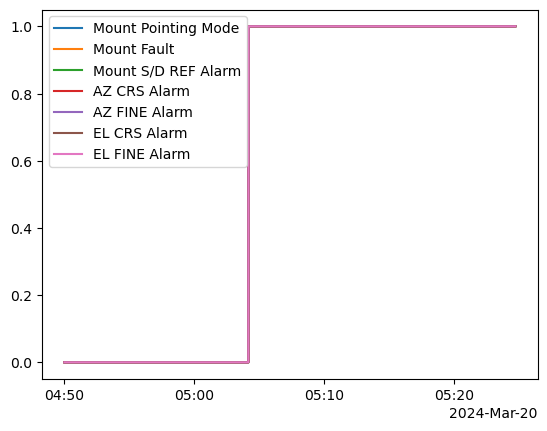

In [12]:
from telDav import FetchData
names = ["Mount Pointing Mode",
         "Mount Fault",
         "Mount S/D REF Alarm",
         "AZ CRS Alarm",
         "AZ FINE Alarm",
         "EL CRS Alarm",
         "EL FINE Alarm"]

fetchData = FetchData.FetchData(startDatetime = '2024-03-20 04:50:00', 
                                stopDatetime =  '2024-03-20 05:30:00',
                                names = names)
fetchData.run()
fetchData.draw()

#### 過去の頻度を調べる

/home/satoshi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


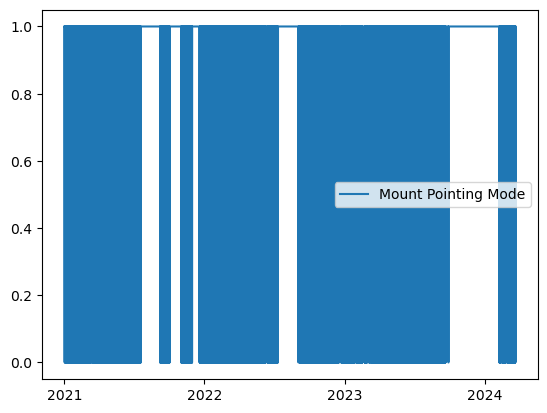

/home/satoshi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


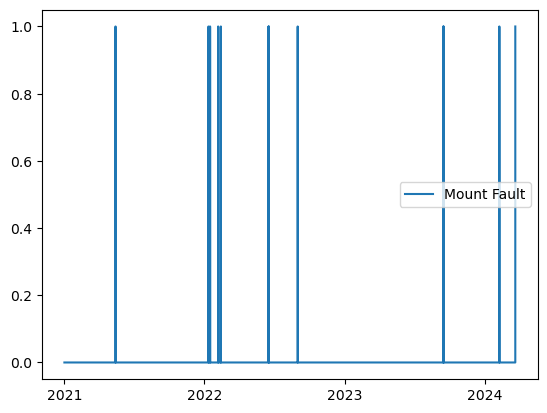

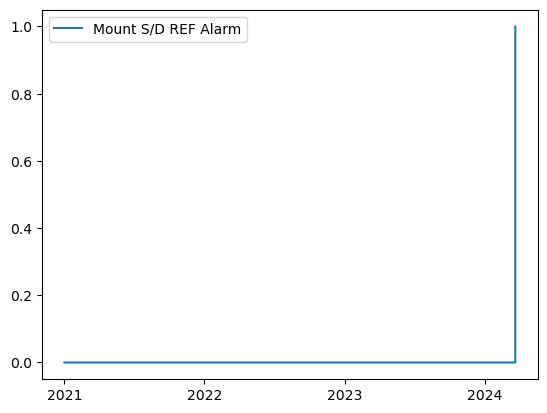

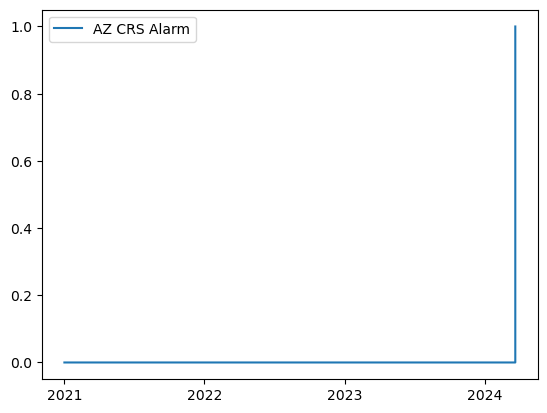

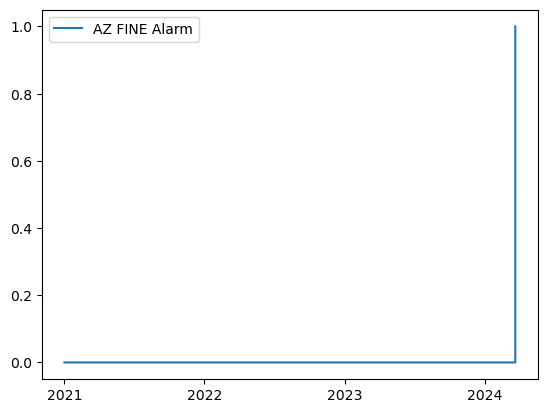

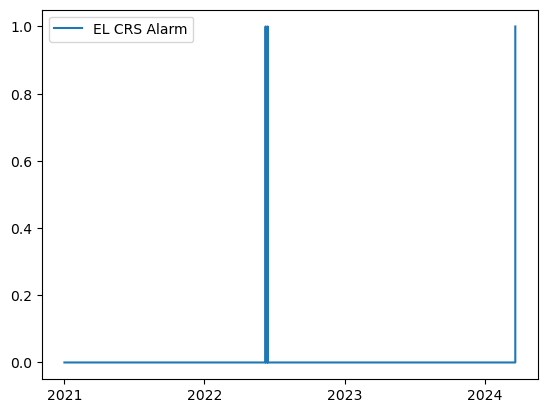

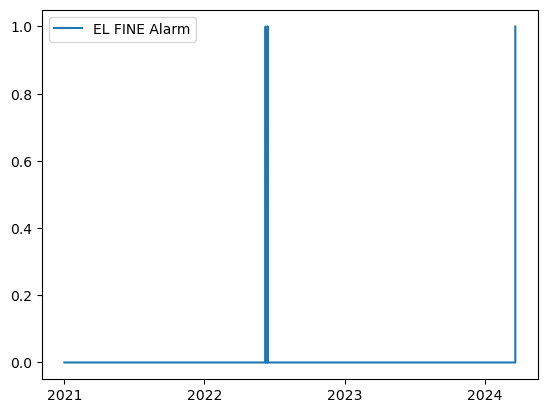

In [11]:
from telDav import FetchData

names = ["Mount Pointing Mode",
         "Mount Fault",
         "Mount S/D REF Alarm",
         "AZ CRS Alarm",
         "AZ FINE Alarm",
         "EL CRS Alarm",
         "EL FINE Alarm"]

for name in names:
    fetchData = FetchData.FetchData(startDatetime = '2021-01-01 00:00:00', 
                                    stopDatetime =  '2024-03-20 05:30:00',
                                    names = [name])
    fetchData.run()
    fetchData.draw()

"Mount Pointing Mode"以外は希な事象であることが分かる。これまで発生がなく、当日が初めてだったのが、"Mount S/D REF Alarm"、"AZ CRS Alarm"、"AZ FINE Alarm"であるが、発生原因と関係あるか？

#### 事象発生時(2024-03-20 05:04:10.8)のコマンドのやり取りを調べる

In [14]:
import datetime
from telDav import ClanMonitor

clanMonitor = ClanMonitor.ClanMonitor(startDatetime=datetime.datetime(2024, 3, 20, 4, 55, 0),
                                      stopDatetime=datetime.datetime(2024, 3, 20, 5, 15, 0))

lines = clanMonitor.run()
for l in lines:
    print(l)

/tscbin/tsc/2024/CLAN_MONITOR.20240320.LOG
2024-03-20 04:57:40.8 CD OCS% > TSC% 0x000566 0x906012 AG Set AG Star1 REF Position 23059 20115
2024-03-20 04:57:40.7 CA TSC% > OCS% 0x000566 0x906012 AG Set AG Star1 REF Position OK 
2024-03-20 04:57:41.0 CE TSC% > OCS% 0x000566 0x906012 AG Set AG Star1 REF Position COMPLETE%% 0006202403201457410
2024-03-20 05:00:01.9 CD TWS4 > TSC% 0x001B3B 0x1A1011 TSC Send Status Data 
2024-03-20 05:00:01.8 CA TSC% > TWS4 0x001B3B 0x1A1011 TSC Send Status Data OK 
2024-03-20 05:00:01.8 CE TSC% > TWS4 0x001B3B 0x1A1011 TSC Send Status Data COMPLETE%% 
2024-03-20 05:01:09.8 CD OCS% > TSC% 0x000567 0x906012 AG Set AG Star1 REF Position 23123 18706
2024-03-20 05:01:09.7 CA TSC% > OCS% 0x000567 0x906012 AG Set AG Star1 REF Position OK 
2024-03-20 05:01:10.0 CE TSC% > OCS% 0x000567 0x906012 AG Set AG Star1 REF Position COMPLETE%% 0006202403201501100
2024-03-20 05:01:19.8 CD OCS% > TSC% 0x000568 0x906012 AG Set AG Star1 REF Position 23182 17406
2024-03-20 05:01:1

特に変なコマンドが投入されたわけではないようだ